In [2]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, pointbiserialr, ttest_ind

In [3]:
nl23_politician_party = {
    'Geert_Wilders': 'PVV',
    'Frans_Timmermans': 'GL-PvdA',
    'Dilan_Yesilgoz': 'VVD',
    'Pieter_Omtzigt': 'NSC',
    'Rob_Jetten': 'D66',
    'Caroline_van_der_Plas': 'BBB',
    'Henri_Bontenbal': 'CDA',
    'Lilian_Marijnissen': 'SP',
    'Thierry_Baudet': 'FVD',
    'Esther_Ouwehand': 'PvdD',
    'Mirjam_Bikker': 'CU',
    'Chris_Stoffer': 'SGP',
    'Stephan_van_Baarle': 'DENK',
    'Laurens_Dassen': 'Volt',
    'Joost_Eerdmans': 'JA21',
    'Edson_Olf': 'Bij1',
    'Wybren_van_Haga': 'BvNL'
}

uk24_politician_party = {
    'Keir_Starmer': 'Labour_Party',                     # Labour / 411 
    'Rishi_Sunak': 'Conservative_Party',                # Conservative / 121
    'Ed_Davey': 'Liberal_Democrats',                    # Liberal Democrats / 72
    'John_Swinney': 'Scottish_National_Party',          # Scottish National Party / 9
    'Mary_Lou_McDonald': 'Sinn_Féin',                   # Sinn Féin / 7
    'Nigel_Farage': 'Reform_UK',                        # Reform UK / 5
    'Gavin_Robinson': 'Democratic_Unionist_Party',      # Democratic Unionist / 5
    'Carla_Denyer': 'Green_Party_of_England_and_Wales', # Green Party of England and Wales / 4
    'Adrian_Ramsay': 'Green_Party_of_England_and_Wales',# Green Party of England and Wales / 4
    'Rhun_ap_Iorwerth': 'Plaid_Cymru',                  # Plaid Cymru / 4
    'Colum_Eastwood': 'Social_Democratic_and_Labour',   # Social Democratic & Labour / 2
    'Jim_Allister': 'Traditional_Unionist_Voice',        # Traditional Unionist Vote / 1
    'Naomi_Long': 'Alliance_Party',                     # Alliance Party / 1
    'Doug_Beattie': 'Ulster_Unionist',                  # Ulster Unionist Party / 1
    'George_Galloway': 'Workers_Party_of_Britain',      # Workers Party / 0 (new)
    'Patrick_Harvie': 'Scottish_Greens',                # Scottish Greens / 0
    'Lorna_Slater': 'Scottish_Greens'                  # Scottish Greens / 0
}

In [4]:
nl_multimodal_df = pd.read_parquet('../e__news-articles-preprocessing-validation/datasets/NL_final_df_multi_modal.parquet')
uk_multimodal_df = pd.read_parquet('../e__news-articles-preprocessing-validation/datasets/UK_final_df_multi_modal.parquet')

In [5]:
def preprocess_lists_week_year(df, pol_party_dict):  
    suffixes = ('__title', '__paragraphs', '__alt_txt')
    cols_to_convert = [col for col in df.columns if col.endswith(suffixes)]

    for col in cols_to_convert:
        df[col] = df[col].apply(lambda x: list(x))

    df['datetime'] = pd.to_datetime(df['datetime'])
    df['date'] = df['datetime'].dt.date
    df['week_year'] = df['datetime'].dt.strftime('%Y-%W')
    df['month_year'] = df['datetime'].dt.to_period('M').astype(str)

    df['politicians_depicted'] = df['politicians_depicted'].apply(
        lambda x: list(x) if isinstance(x, (list, np.ndarray)) else None
        )
    df['parties_depicted'] = df['politicians_depicted'].apply(
        lambda x: [pol_party_dict.get(p) for p in x] if isinstance(x, list) else None
        )
    return df
    
nl_multimodal_df = preprocess_lists_week_year(nl_multimodal_df, nl23_politician_party)
uk_multimodal_df = preprocess_lists_week_year(uk_multimodal_df, uk24_politician_party)
uk_multimodal_df = uk_multimodal_df[uk_multimodal_df['week_year'] <= '2024-35']

In [6]:
#nl_multimodal_df[nl_multimodal_df['politicians_depicted'].notna()].tail()
#uk_multimodal_df[uk_multimodal_df['politicians_depicted'].notna()].tail()

In [7]:
print(f'Shape of the final data for NL: {nl_multimodal_df.shape}')
print(f'Shape of the final data for UK: {uk_multimodal_df.shape}')

Shape of the final data for NL: (11915, 85)
Shape of the final data for UK: (82209, 79)


In [8]:
uk_multimodal_df['outlet'].value_counts()

outlet
BBC             50612
The Guardian    31597
Name: count, dtype: int64

### 1. Subset data for analysis
a. pol_img_only // only articles with political images <br>
b. pol_ref_results // per politician metric showing if per-article coverage was multi-modal or mono-modal

In [9]:
def subset_data_for_analysis(df, pol_party_dict, img_clf_column):
    pol_img_only = df[df[img_clf_column].notna()]

    pol_ref_results = []
    for i, row in pol_img_only.iterrows():
        for clf in row['politicians_depicted']:
            party = pol_party_dict[clf]
            column_to_check = f'{party}__title'
            value = len(row[column_to_check]) > 0
            pol_ref = {
                'dataset': row['outlet'],
                'id': row['id'],
                'id_unique': row['id_unique'],
                'url': row['url'],
                'title': row['title'],
                'politicians_depicted': row['politicians_depicted'],
                'per_politician': clf,
                'ref_in_title': value,
                'ref': row[column_to_check]
            }
            pol_ref_results.append(pol_ref)

    return pol_img_only, pd.DataFrame(pol_ref_results)

In [10]:
nl_pol_img_only, nl_pol_ref_results = subset_data_for_analysis(nl_multimodal_df, nl23_politician_party, 'politicians_depicted')
uk_pol_img_only, uk_pol_ref_results = subset_data_for_analysis(uk_multimodal_df, uk24_politician_party, 'politicians_depicted')

In [11]:
# Uncomment to check
#uk_pol_img_only.tail()

## 2. Compute daily, monthly modality scores to inspect modality patterns
a. text // title * 2 + paragraphs count <br>
b. title // title reference (binary) <br>
c. img // img reference (binary)

In [12]:
def count_vis_text_occurrences(df, pol_party_dict):
    party_list = list(set(pol_party_dict.values()))
    
    new_columns = {
        **{f"{party}__text_count": 0 for party in party_list},
        **{f"{party}__title_count": 0 for party in party_list},
        **{f"{party}__img_count": 0 for party in party_list}
    }
    df = df.assign(**new_columns)
    
    img_col = 'parties_depicted'
    for party in party_list:
        title_col = f"{party}__title"
        para_col = f"{party}__paragraphs"
        
        if title_col in df.columns:
            df[f"{party}__title_count"] = df[title_col].apply(
                lambda x: 1 if isinstance(x, list) and len(x) > 0 else 0
            )
        
        if title_col in df.columns and para_col in df.columns:
            df[f"{party}__text_count"] = (
                df[title_col].apply(lambda x: len(x) if isinstance(x, list) else 0) * 2 +
                df[para_col].apply(lambda x: len(x) if isinstance(x, list) else 0)
            )
        
        if img_col in df.columns:
            df[f"{party}__img_count"] = df[img_col].apply(
                lambda lst: 1 if isinstance(lst, list) and party in lst else 0
            )

    def melt_and_aggregate(suffix):
        melted = df.melt(
            id_vars=['date', 'week_year', 'month_year'],
            value_vars=[f"{party}__{suffix}" for party in party_list],
            var_name='party',
            value_name='count'
        )
        melted['party'] = melted['party'].str.replace(f'__{suffix}', '', regex=False)

        daily = (
            melted.groupby(['date', 'party'])['count']
            .sum()
            .unstack(fill_value=0)[party_list]
        )
        weekly = (
            melted.groupby(['week_year', 'party'])['count']
            .sum()
            .unstack(fill_value=0)[party_list]
        )
        monthly = (
            melted.groupby(['month_year', 'party'])['count']
            .sum()
            .unstack(fill_value=0)[party_list]
        )
        return {"melted": melted, "daily": daily, "weekly": weekly, "monthly": monthly}
    
    results = {
        "text": melt_and_aggregate("text_count"),
        "title": melt_and_aggregate("title_count"),
        "img": melt_and_aggregate("img_count")
    }
    
    return df, results


In [13]:
# Uncomment to check
#test_df, test_results = count_vis_text_occurrences(nl_multimodal_df, nl23_politician_party)
#test_df_check = test_df[test_df['politicians_depicted'].notna()]
#test_df_check[['title', 'politicians_depicted', 'PVV__img_count', 'PVV__title', 'PVV__title_count', 'PVV__paragraphs', 'PVV__text_count']]
#test_results['title']['monthly']

In [14]:
nl_multimodal_counted, nl_multimodal_results = count_vis_text_occurrences(nl_multimodal_df, nl23_politician_party)
uk_multimodal_counted, uk_multimodal_results = count_vis_text_occurrences(uk_multimodal_df, uk24_politician_party)

In [38]:
def dual_ax_coverage_vis_old(df_text, df_vis, filename, pol_party_dict, time_period='weekly'):

    max_textual = df_text.max().max() * 1.1
    max_visual = df_vis.max().max() * 1.1 

    all_parties = list(pol_party_dict.values())
    num_parties = len(all_parties)

    if time_period == 'weekly':
        x_labels = df_text.index.str.split('-').str[1]
        x_label_name = 'Week'
    elif time_period == 'biweekly':
        x_labels = df_text.index.str.split('-').str[1]
        x_label_name = 'Bi-Week'
    elif time_period == 'monthly':
        x_labels = df_text.index.str.split('-').str[1]
        x_label_name = 'Month'
    else:
        raise ValueError("time_period must be 'weekly', 'biweekly', or 'monthly'.")

    fig, axes = plt.subplots(nrows=(num_parties // 3) + 1, ncols=3, figsize=(15, 24))
    axes = axes.flatten()

    for idx, party in enumerate(all_parties):
        ax = axes[idx]
        ax2 = ax.twinx()
        
        ax.plot(x_labels, 
                df_text[party], 
                color='cornflowerblue', 
                label='Textual appearances')
        ax.set_ylim(0, max_textual)
        
        ax2.plot(x_labels, 
                df_vis[party], 
                color='darkorange', 
                label='Visual appearances')
        ax2.set_ylim(0, max_visual)
        
        ax.set_title(f'{party}')
        ax.set_xlabel(x_label_name)
        ax.set_ylabel('Textual count', color='cornflowerblue')
        ax2.set_ylabel('Visual count', color='darkorange')
        
        ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
        ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.9))

    for ax in axes[num_parties:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.savefig(f'../z__visual-outputs-matplotlib/{filename}', format='pdf', bbox_inches='tight')
    plt.show()

def dual_ax_coverage_vis(df_text, df_vis, filename, pol_party_dict, time_period='weekly'):
    import matplotlib.pyplot as plt

    max_textual = df_text.max().max() * 1.1
    max_visual = df_vis.max().max() * 1.1 

    all_parties = list(pol_party_dict.values())
    num_parties = len(all_parties)

    if time_period == 'weekly':
        x_labels = df_text.index.str.split('-').str[1].astype(int)
        x_label_name = 'Week'
    elif time_period == 'biweekly':
        x_labels = df_text.index.str.split('-').str[1].astype(int)
        x_label_name = 'Bi-Week'
    elif time_period == 'monthly':
        x_labels = df_text.index.str.split('-').str[1].astype(int)
        x_label_name = 'Month'
    else:
        raise ValueError("time_period must be 'weekly', 'biweekly', or 'monthly'.")

    # 4 graphs per row
    ncols = 4
    nrows = (num_parties // ncols) + (1 if num_parties % ncols != 0 else 0)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))
    axes = axes.flatten()

    for idx, party in enumerate(all_parties):
        ax = axes[idx]
        ax2 = ax.twinx()

        ax.plot(x_labels, df_text[party], color='cornflowerblue')
        ax.set_ylim(0, max_textual)

        ax2.plot(x_labels, df_vis[party], color='darkorange')
        ax2.set_ylim(0, max_visual)

        ax.set_title(f'{party}')
        ax.set_xlabel(x_label_name)
        ax.set_ylabel('Textual count', color='cornflowerblue')
        ax2.set_ylabel('Visual count', color='darkorange')

        # Show only every 3rd label on the x-axis
        ax.set_xticks(x_labels[::3])

    # Hide unused subplots
    for ax in axes[num_parties:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.savefig(f'../z__visual-outputs-matplotlib/{filename}', format='pdf', bbox_inches='tight')
    plt.show()


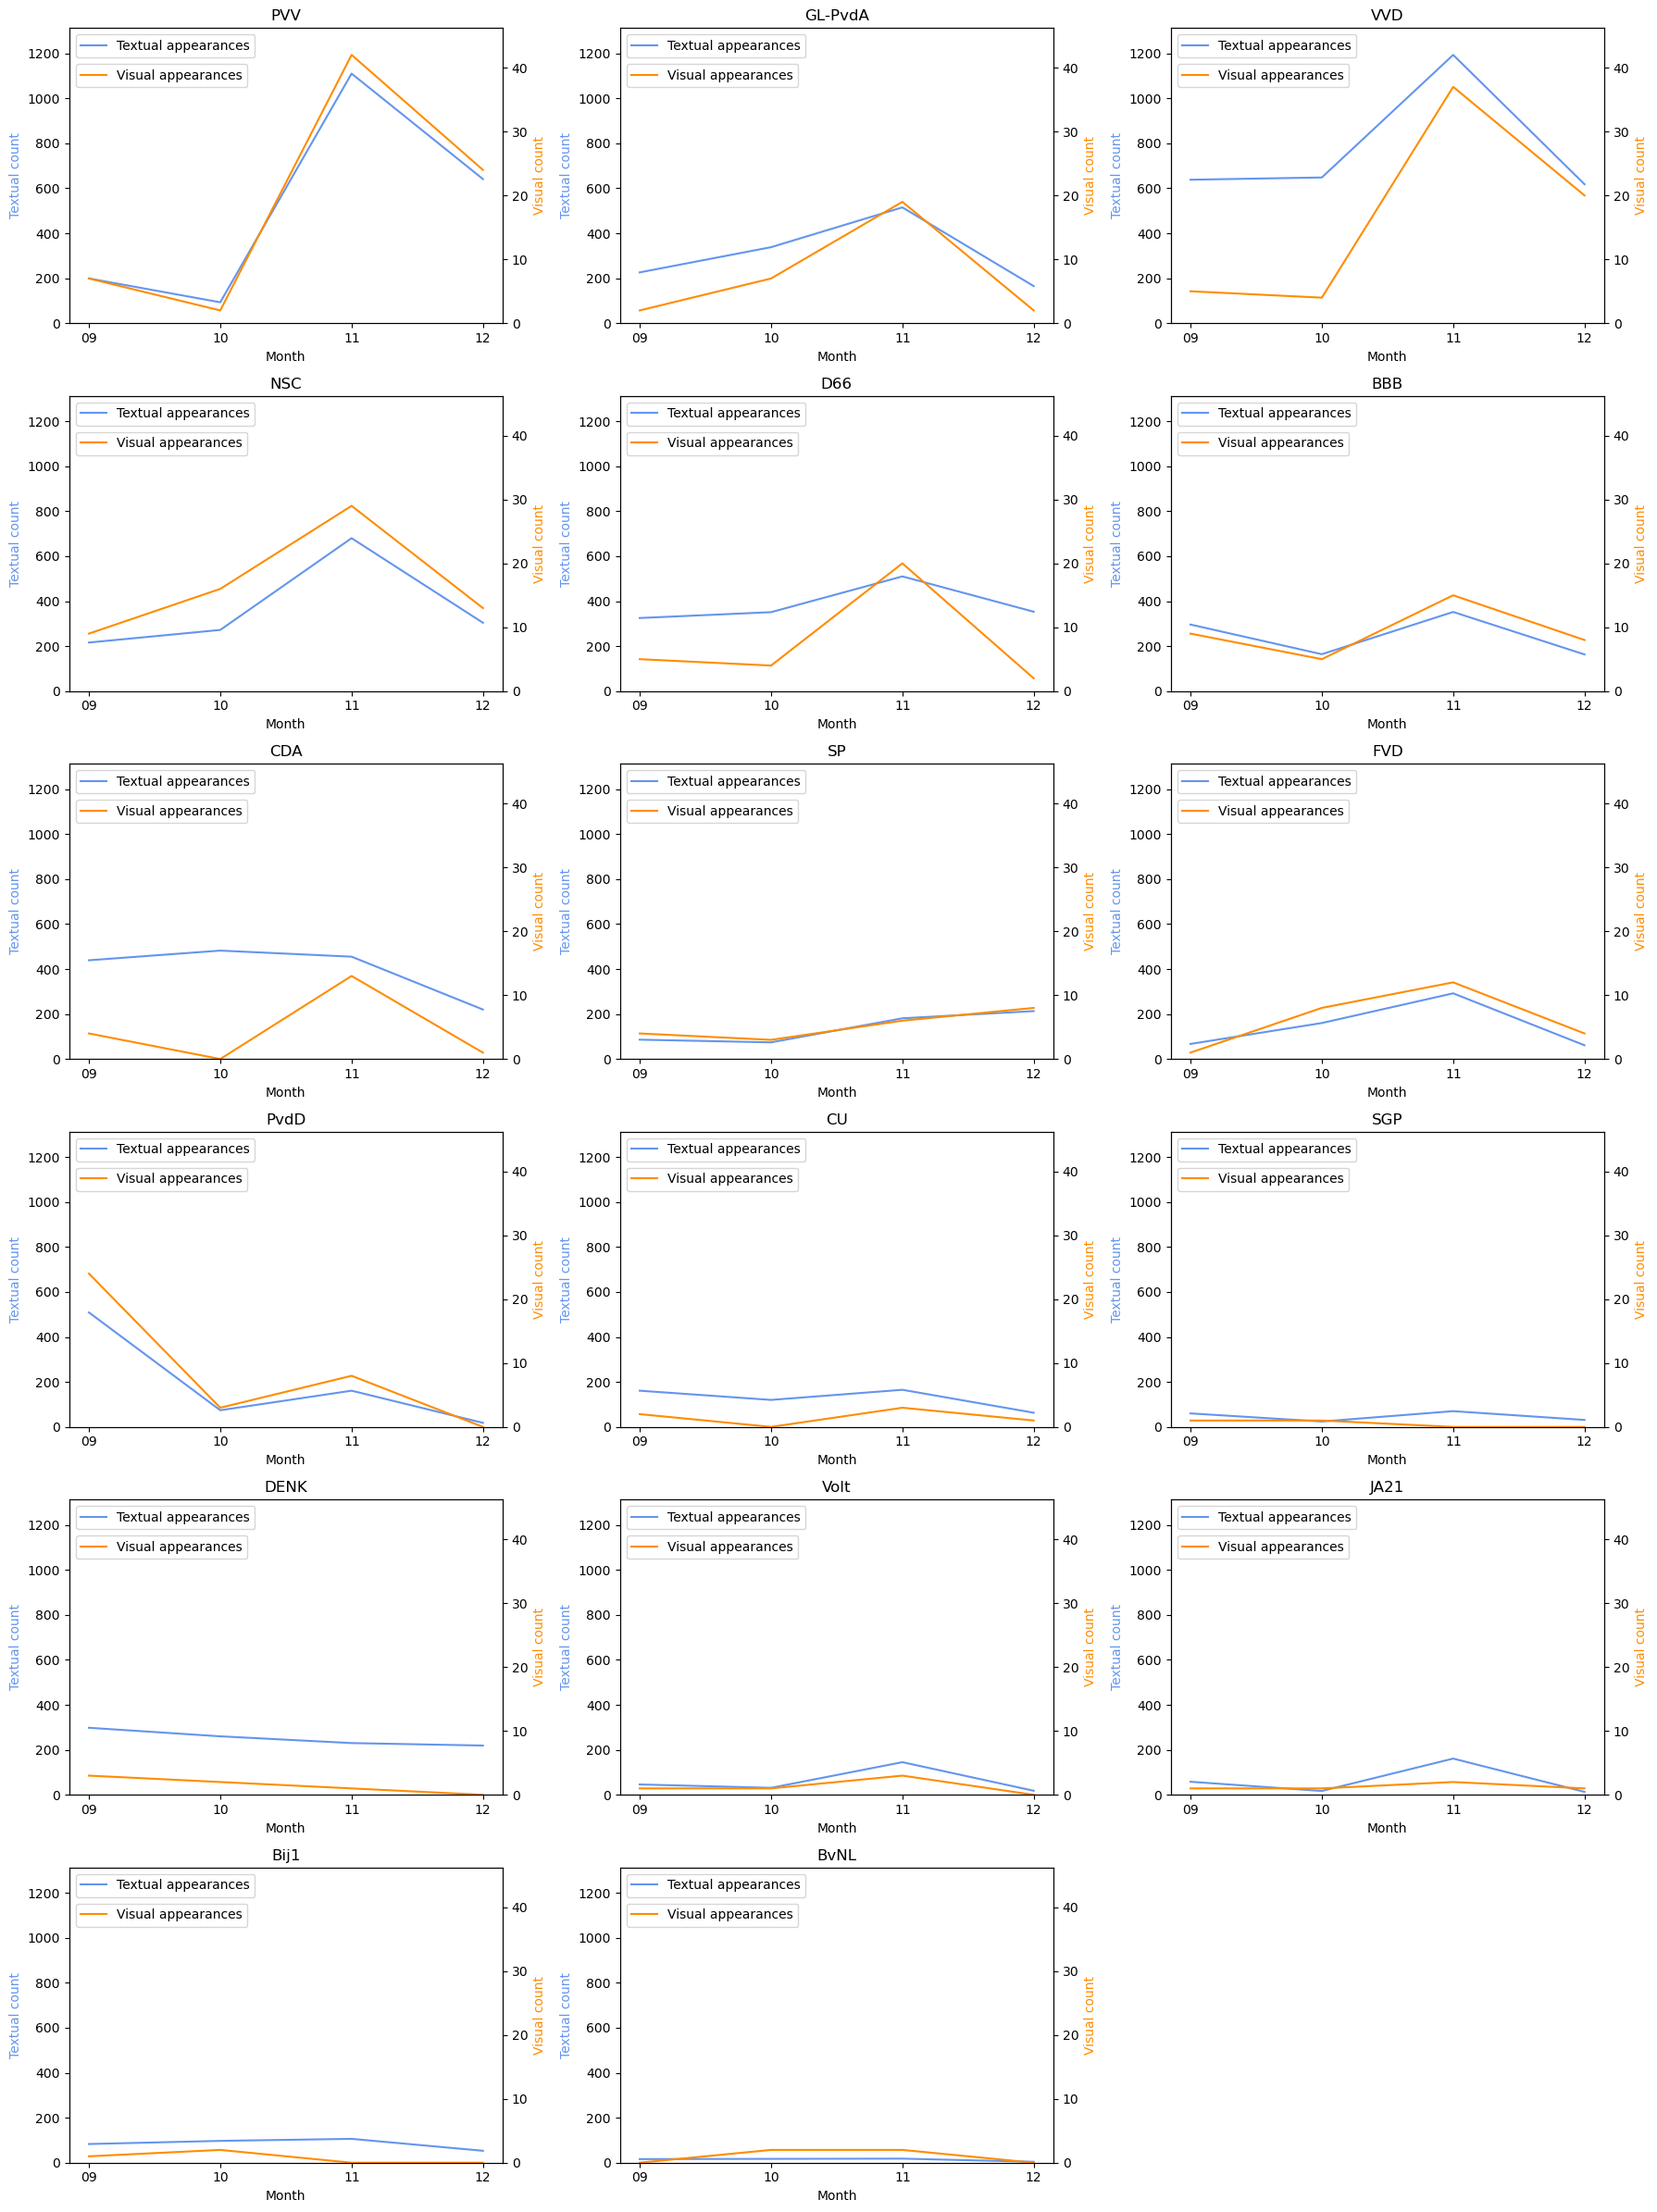

In [ ]:
dual_ax_coverage_vis_old(nl_multimodal_results['text']['monthly'], nl_multimodal_results['img']['monthly'], 'NL_dual_ax_multi_modal_month.pdf', nl23_politician_party, time_period='monthly')

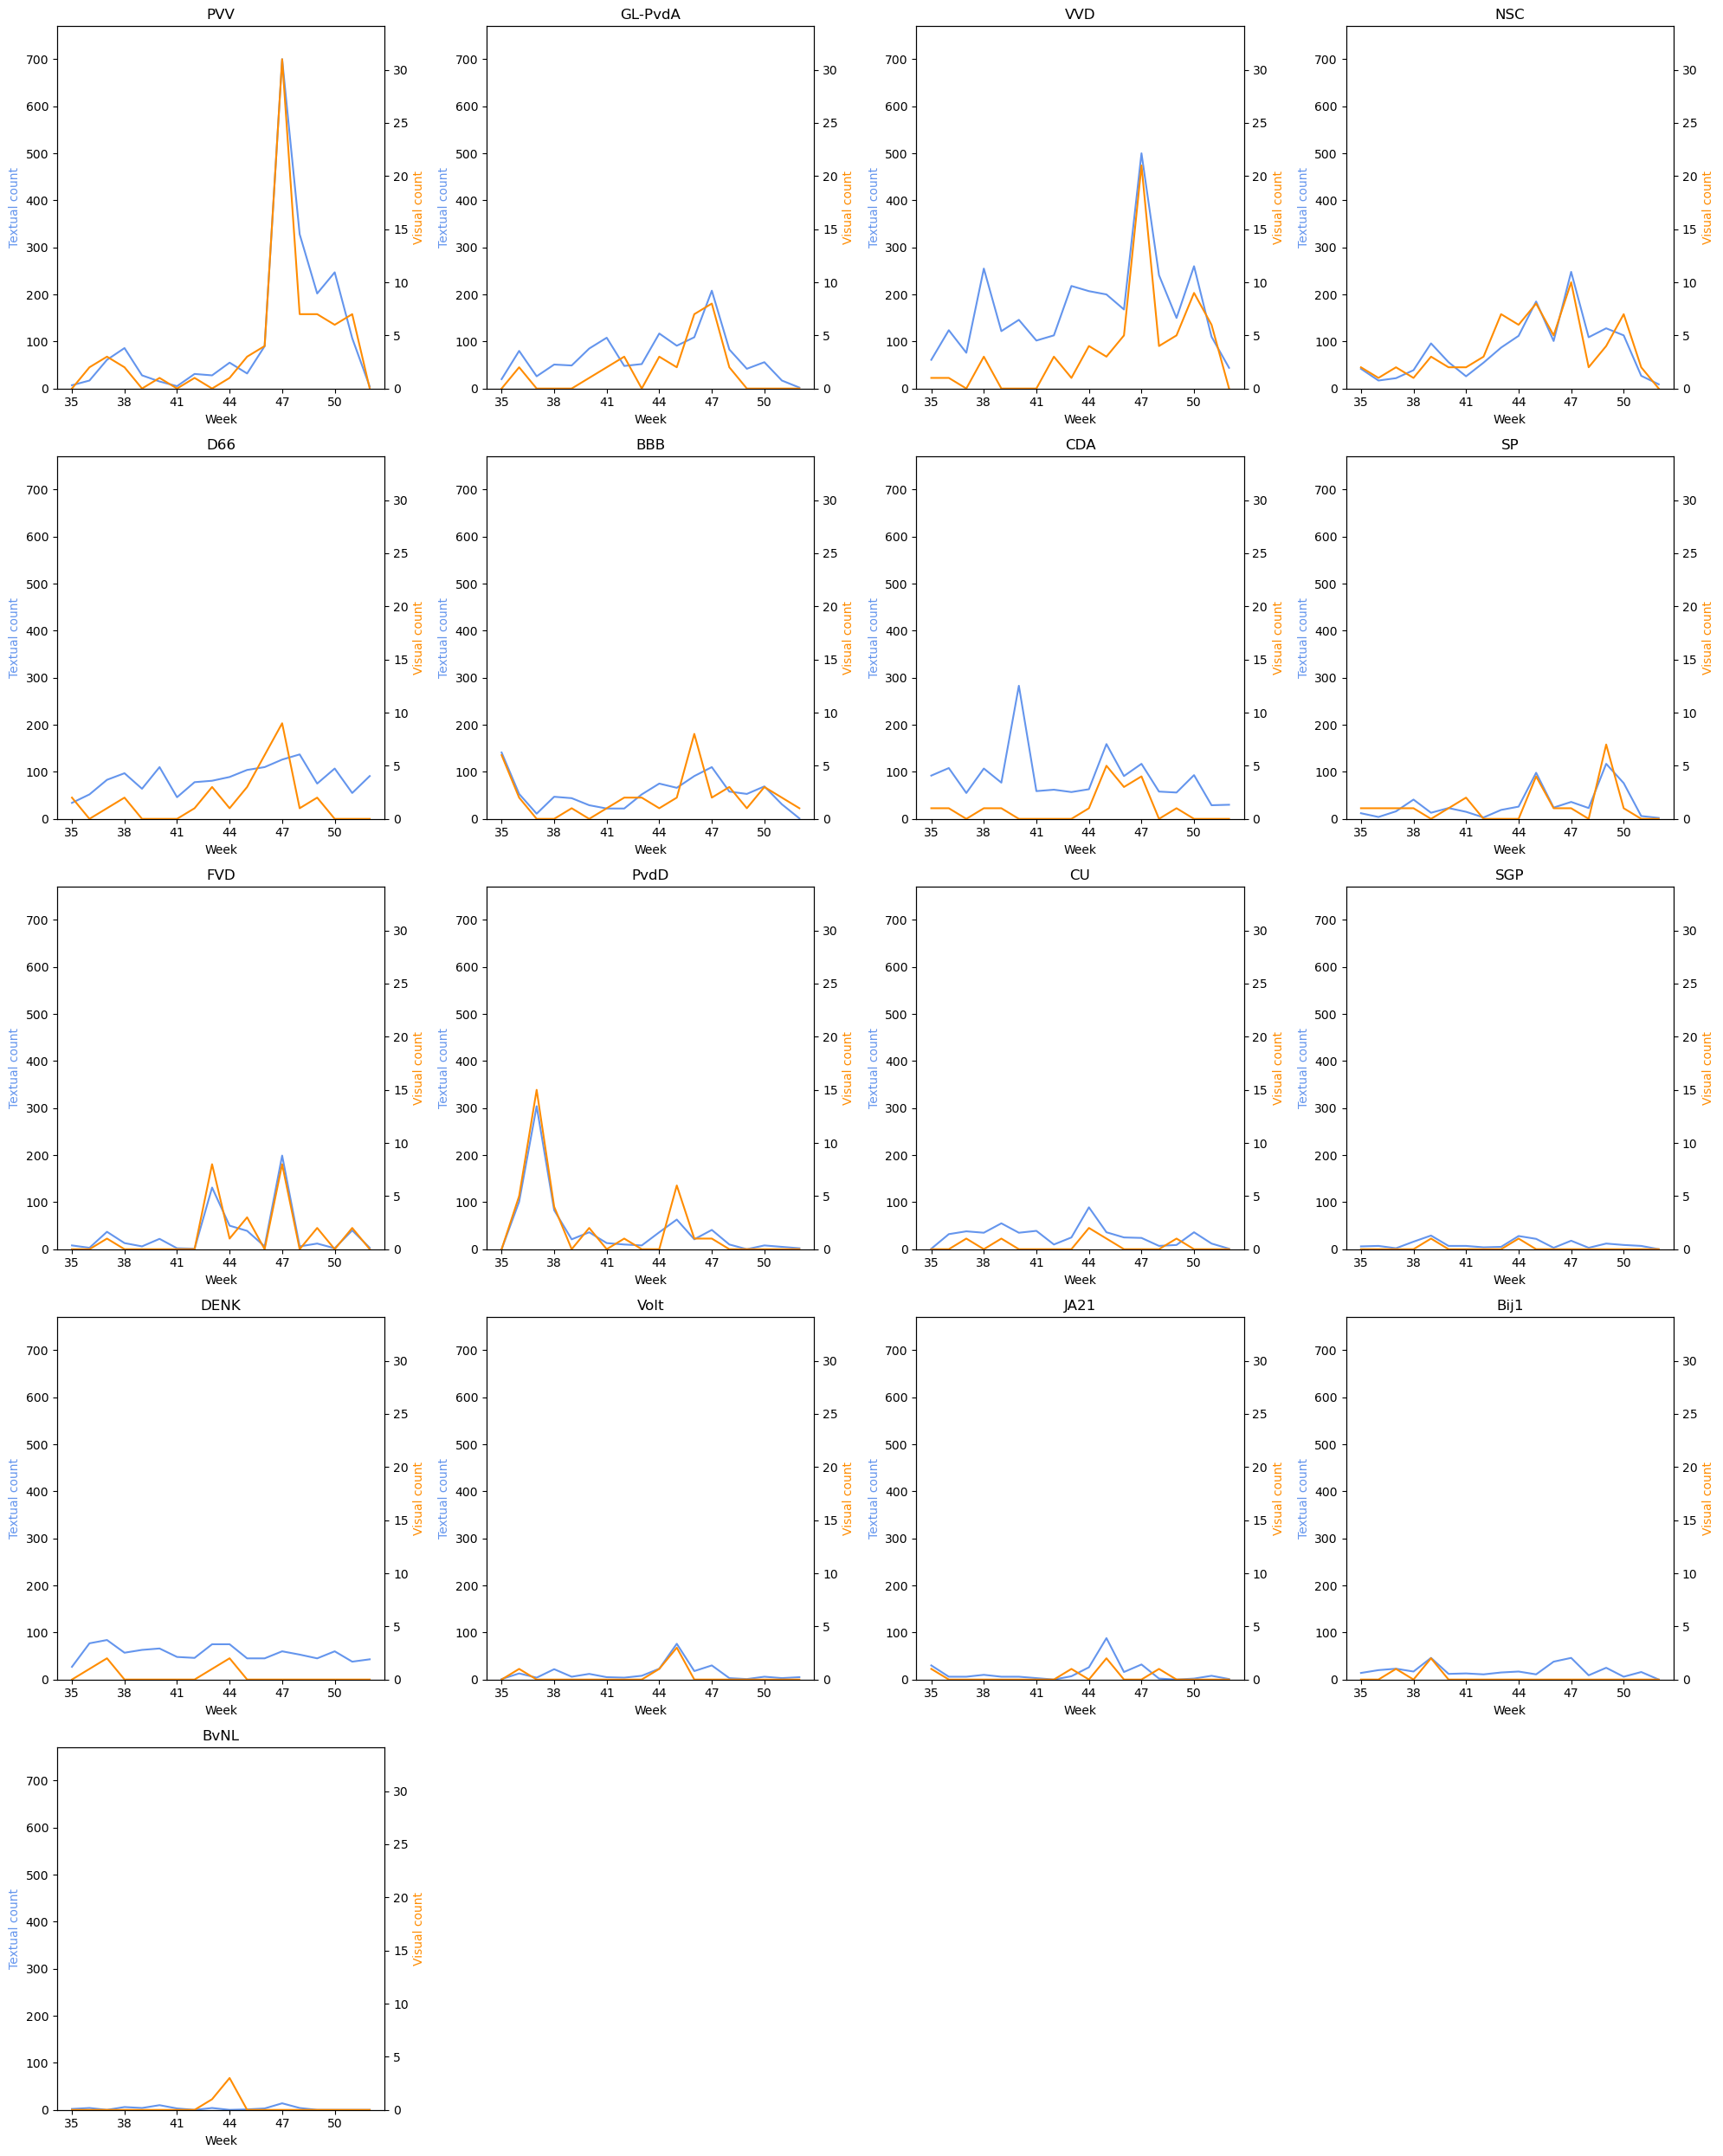

In [39]:
dual_ax_coverage_vis(nl_multimodal_results['text']['weekly'], nl_multimodal_results['img']['weekly'], 'NL_dual_ax_multi_modal_week.pdf', nl23_politician_party, time_period='weekly')

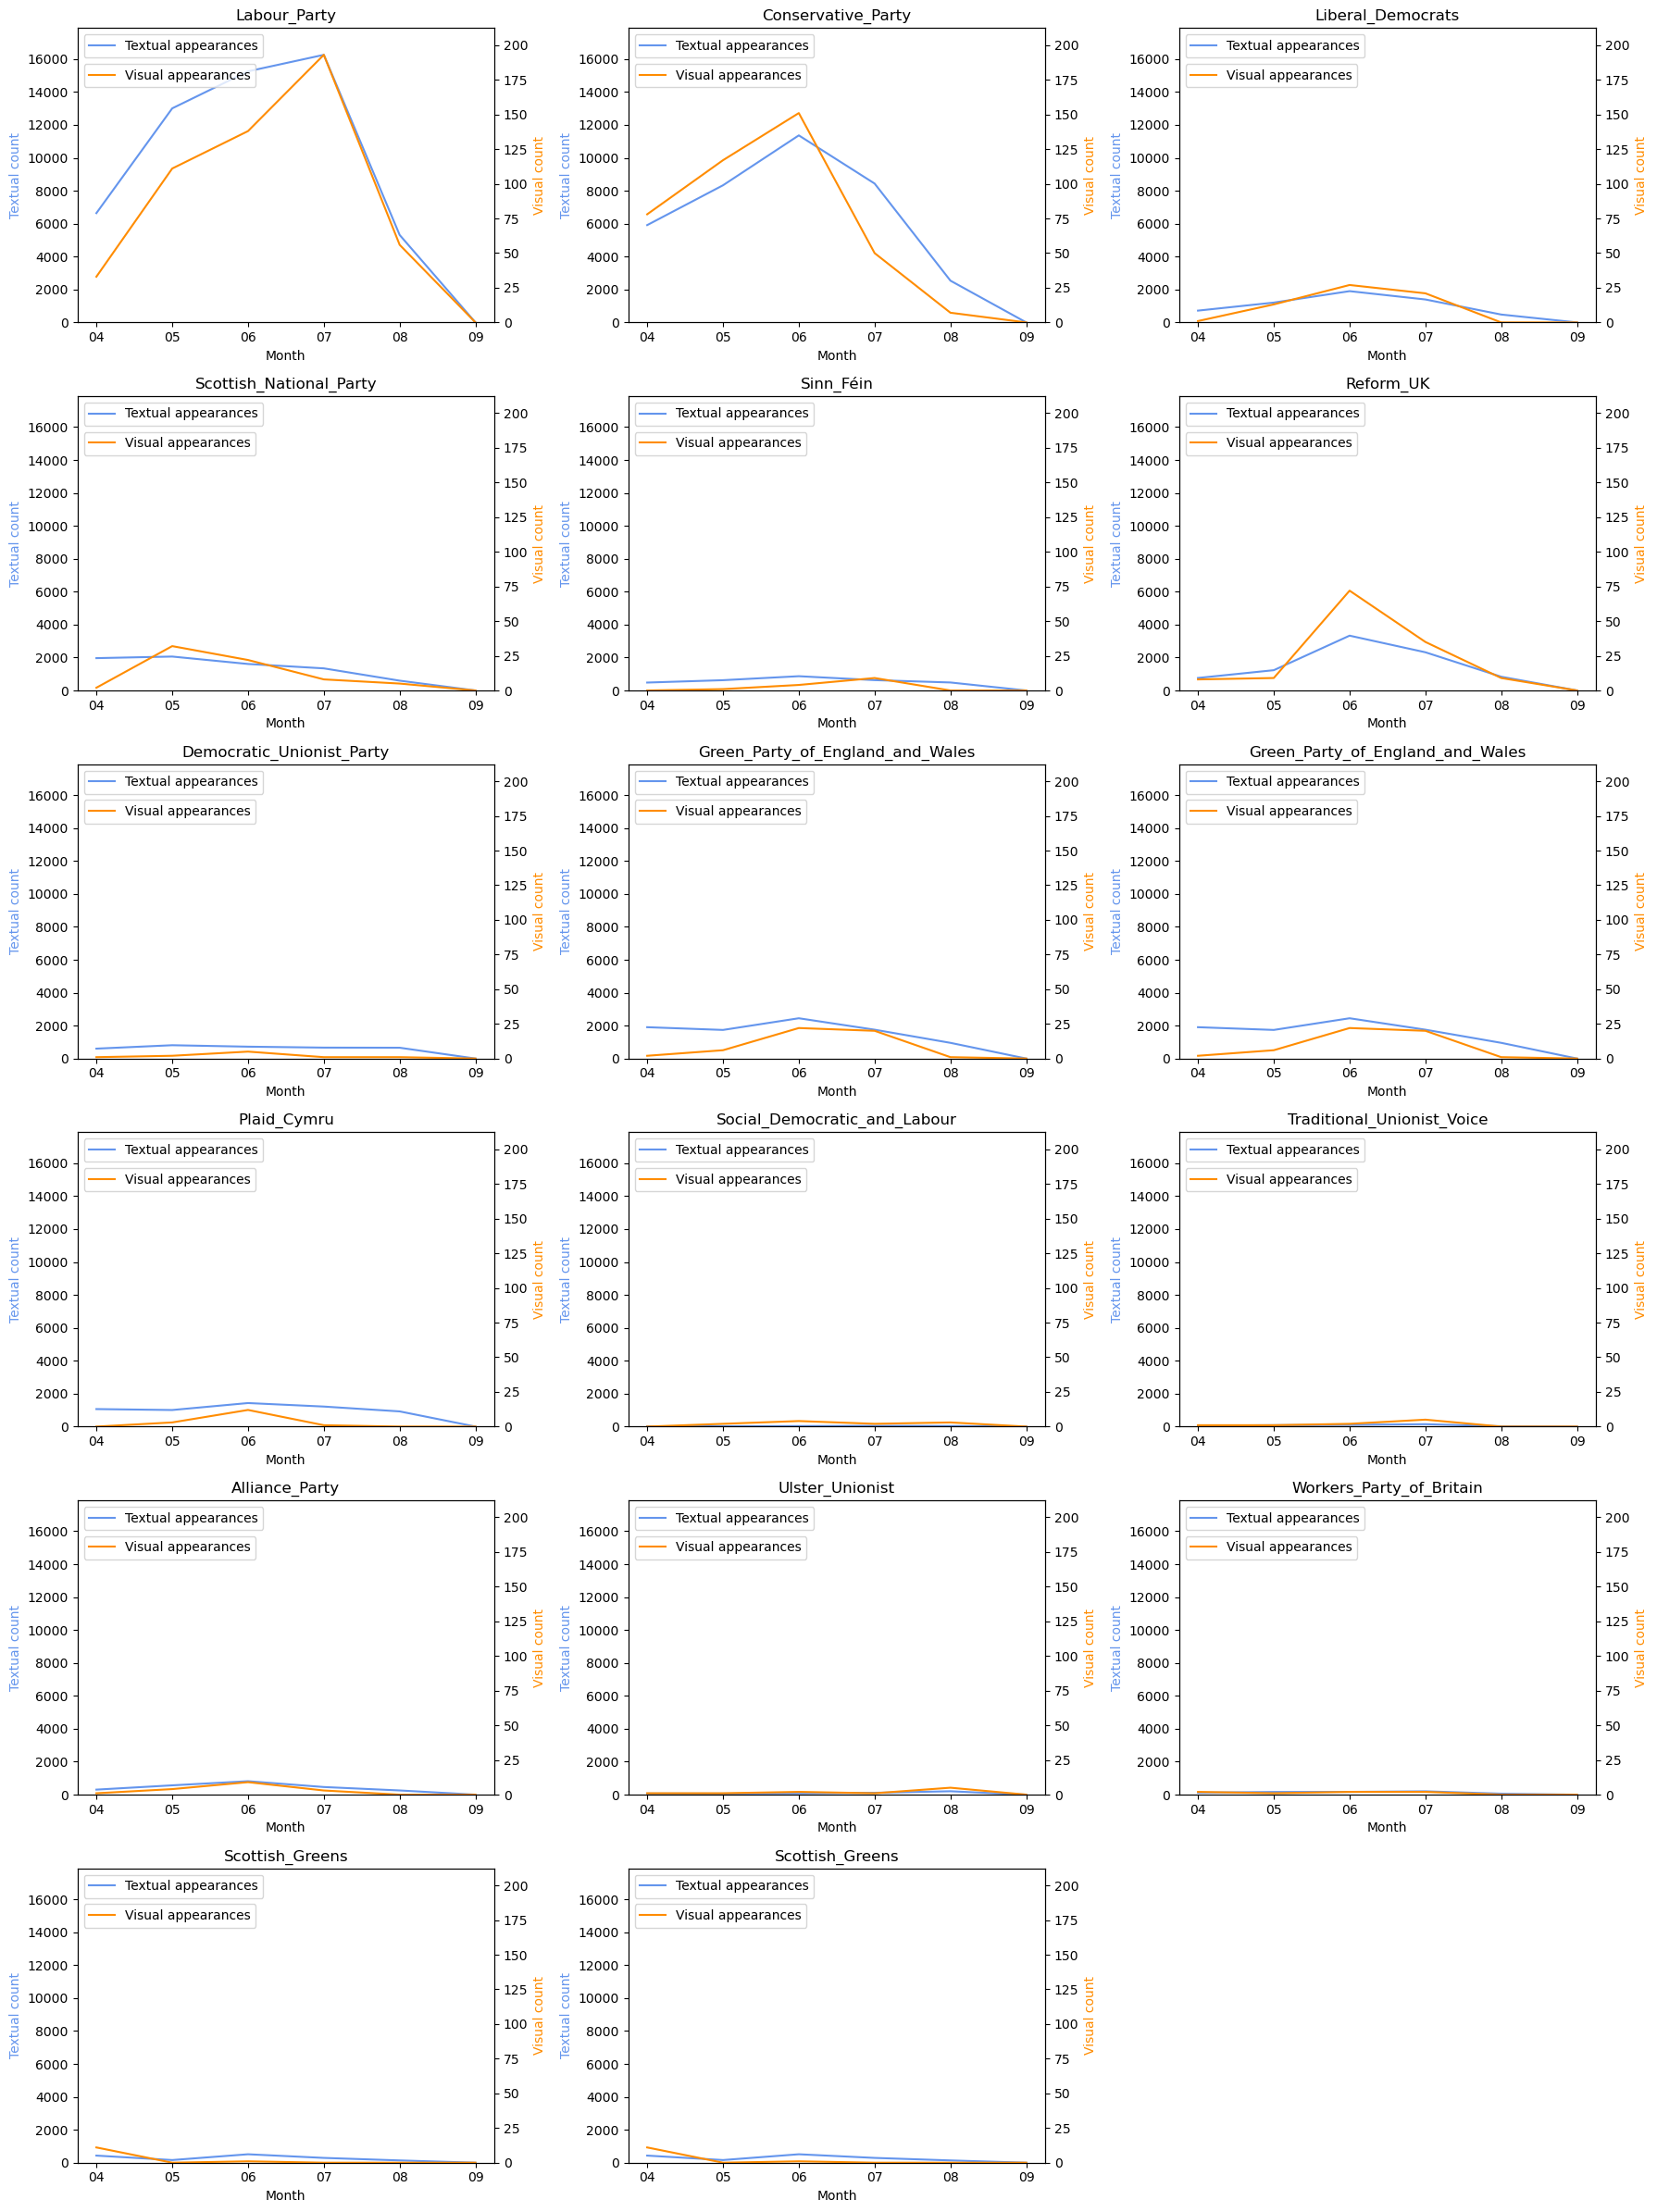

In [18]:
dual_ax_coverage_vis(uk_multimodal_results['text']['monthly'], uk_multimodal_results['img']['monthly'], 'UK_dual_ax_multi_modal_month.pdf', uk24_politician_party, time_period='monthly')

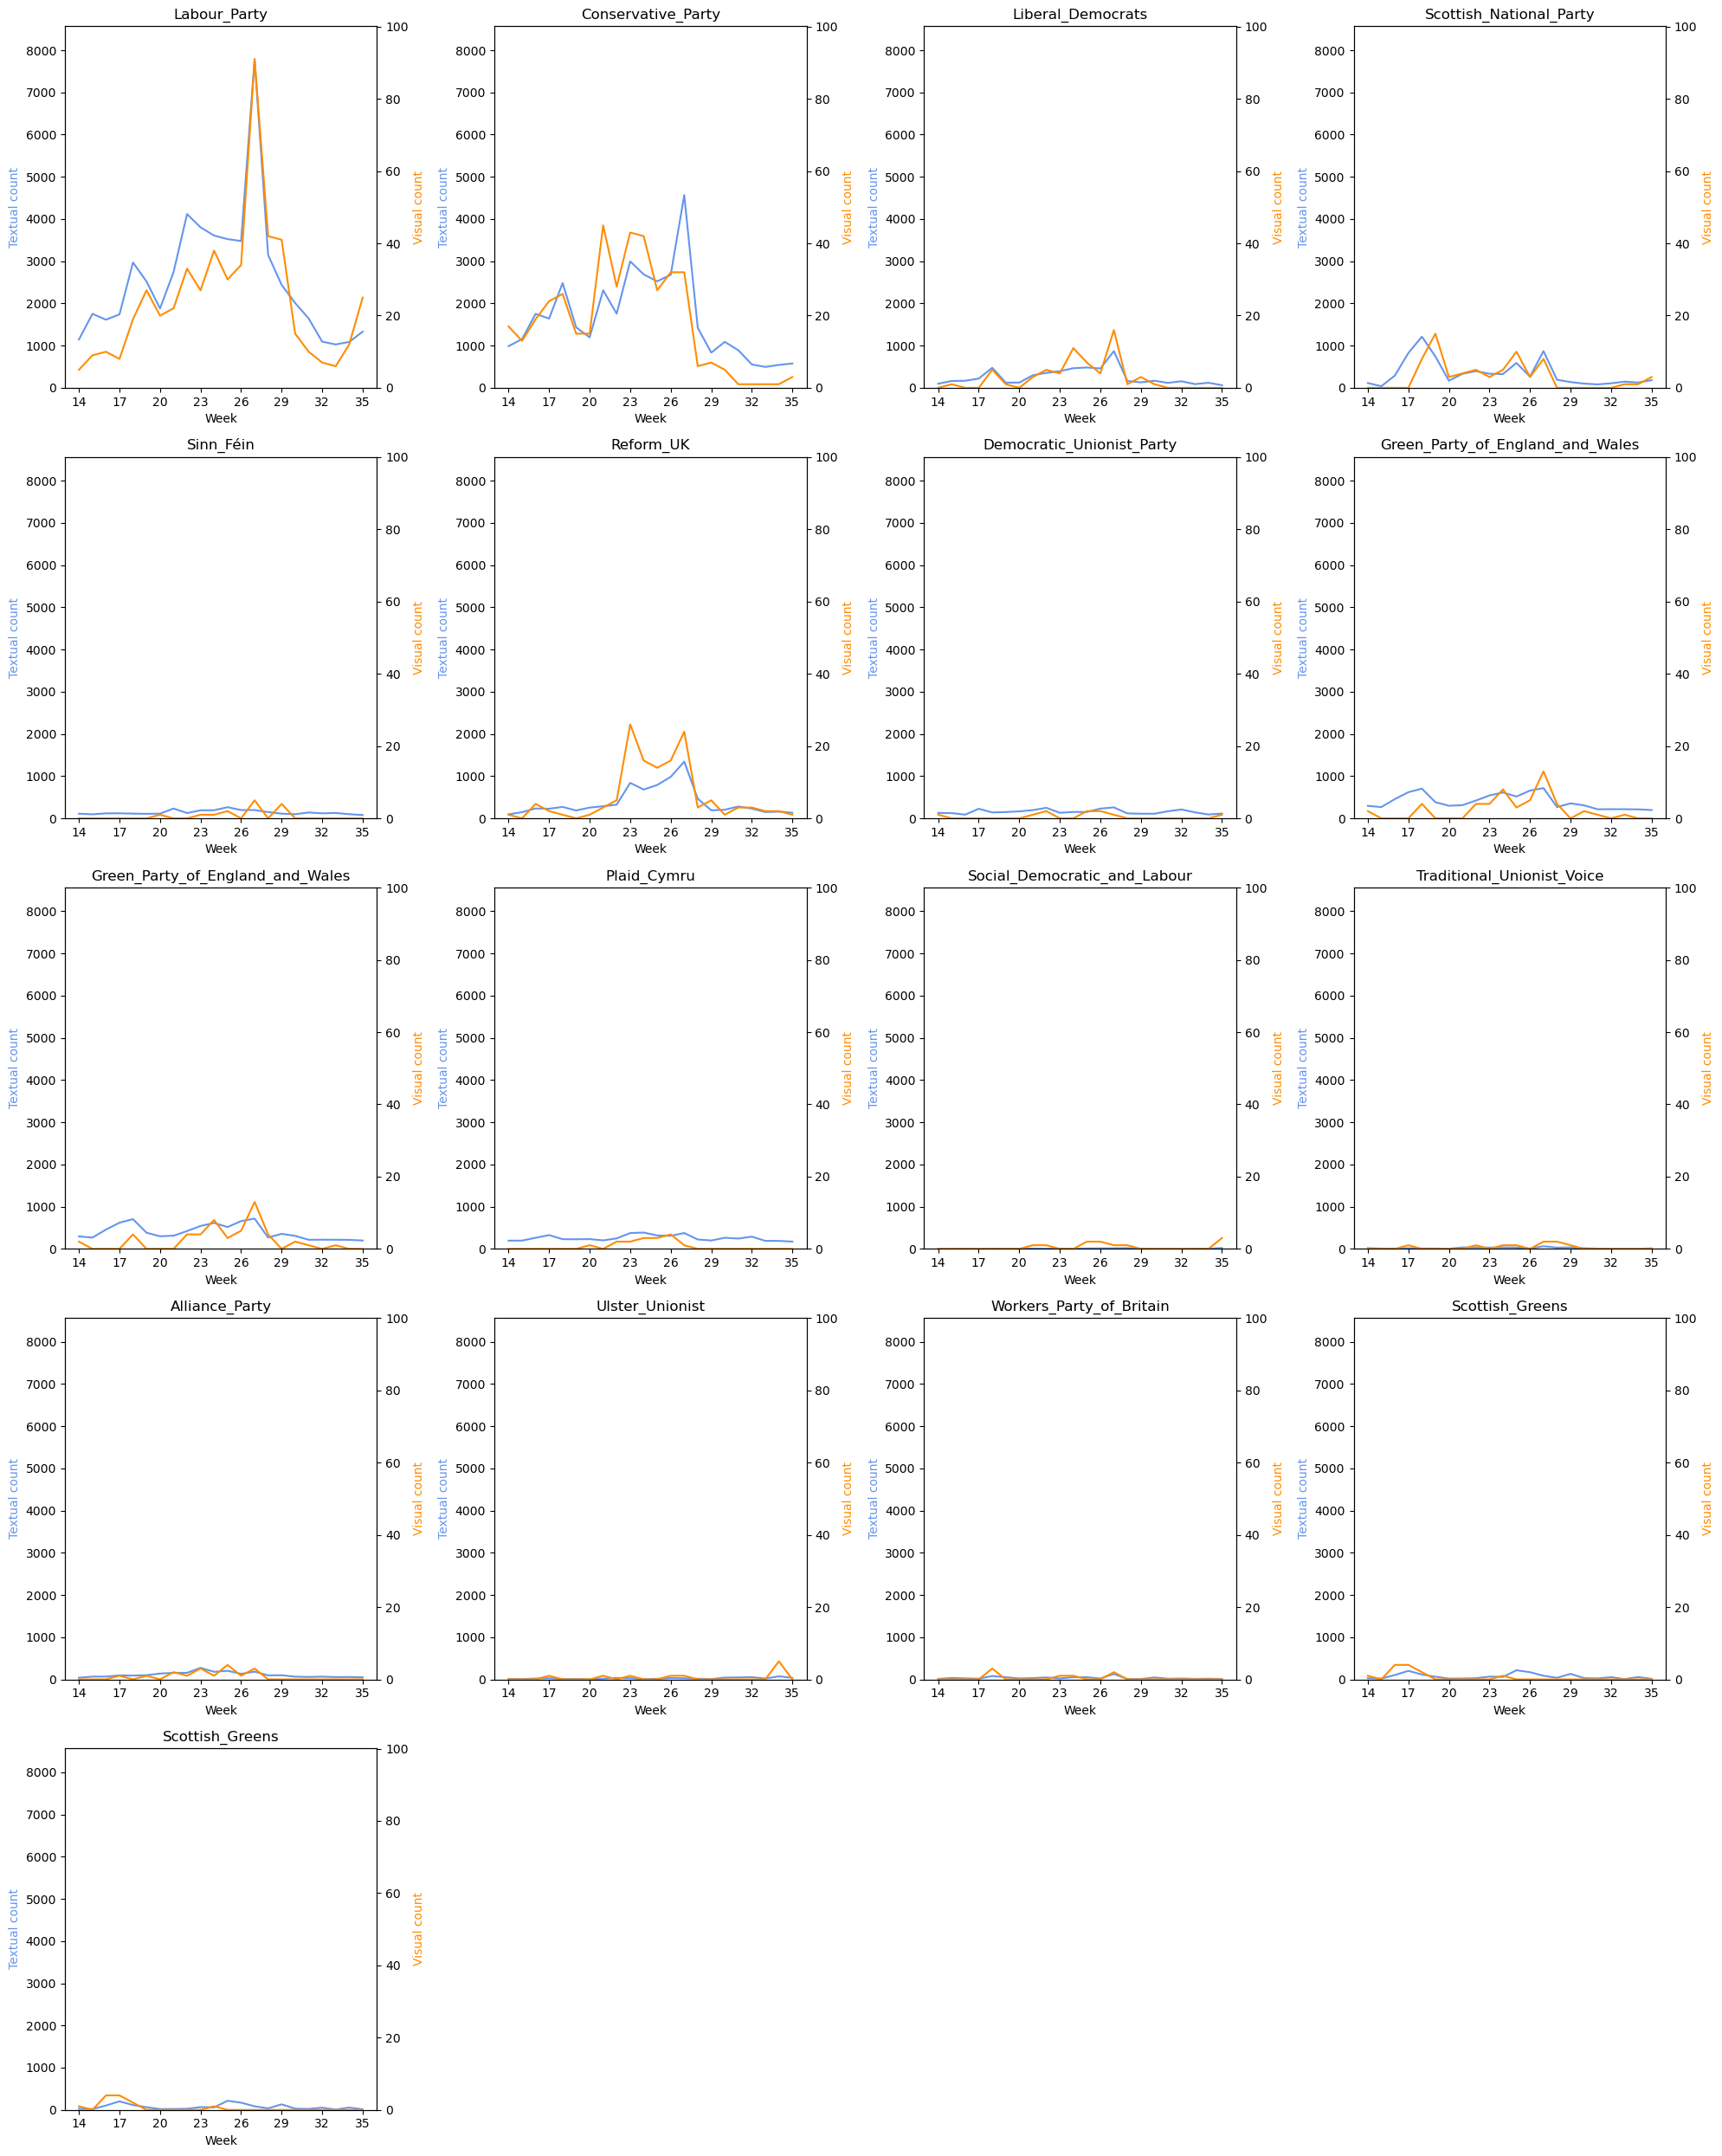

In [40]:
dual_ax_coverage_vis(uk_multimodal_results['text']['weekly'], uk_multimodal_results['img']['weekly'], 'UK_dual_ax_multi_modal_week.pdf', uk24_politician_party, time_period='weekly')

## 3. Compute correlations between modalities

In [19]:
def correlate_modalities(df, pol_party_dict, text_mod):
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    party_modalities = []
    
    for party in pol_party_dict.values():
        text_count = df[f"{party}__{text_mod}_count"]
        img_count = df[f"{party}__img_count"]
        
        text_count_norm = zscore(text_count)
        img_count_norm = zscore(img_count)

        score = {
            'party': party,
            'pearson_corr_article': np.round(pd.Series(text_count_norm).corr(pd.Series(img_count_norm)), 3)
        }

        cols_to_sum = [f"{party}__{text_mod}_count", f"{party}__img_count"]

        daily_df = df[cols_to_sum].resample('D').sum()
        if not daily_df.empty:
            daily_text_norm = zscore(daily_df[f"{party}__{text_mod}_count"])
            daily_img_norm = zscore(daily_df[f"{party}__img_count"])
            score['pearson_corr_daily'] = np.round(pd.Series(daily_text_norm).corr(pd.Series(daily_img_norm)), 3)
        else:
            score['pearson_corr_daily'] = None
        
        party_modalities.append(score)
    
    party_modalities_df = pd.DataFrame(party_modalities)

    return party_modalities_df

In [44]:
def plot_correlation_heatmap(corr_df, text_mod, country):
    corr_df = corr_df.set_index('party')
    
    plt.figure(figsize=(5, 8))
    sns.heatmap(
        corr_df,
        annot=True, 
        cmap='Grays', 
        fmt=".3f",
        linewidths=.5,
        linecolor='white',
        yticklabels=corr_df.index
    )
    plt.title(f'{country} - Pearson Correlation\n[{text_mod}_count] & [img_count]\n', fontsize=16)
    plt.xlabel('Time Aggregation', fontsize=12)
    plt.ylabel('Political Party', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [21]:
nl_corr_text = correlate_modalities(nl_multimodal_counted, nl23_politician_party, 'text')
uk_corr_text = correlate_modalities(uk_multimodal_counted, uk24_politician_party, 'text')

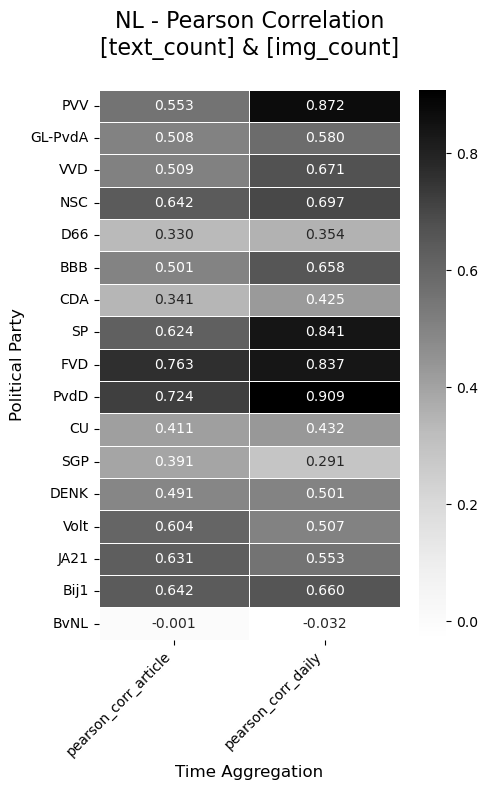

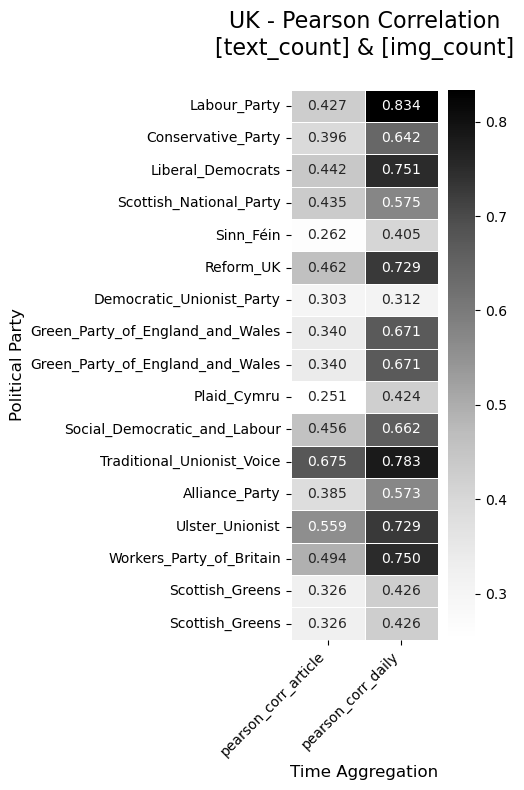

In [22]:
plot_correlation_heatmap(nl_corr_text, 'text', 'NL')
plot_correlation_heatmap(uk_corr_text, 'text', 'UK')

In [23]:
nl_corr_title = correlate_modalities(nl_multimodal_counted, nl23_politician_party, 'title')
uk_corr_title = correlate_modalities(uk_multimodal_counted, uk24_politician_party, 'title')

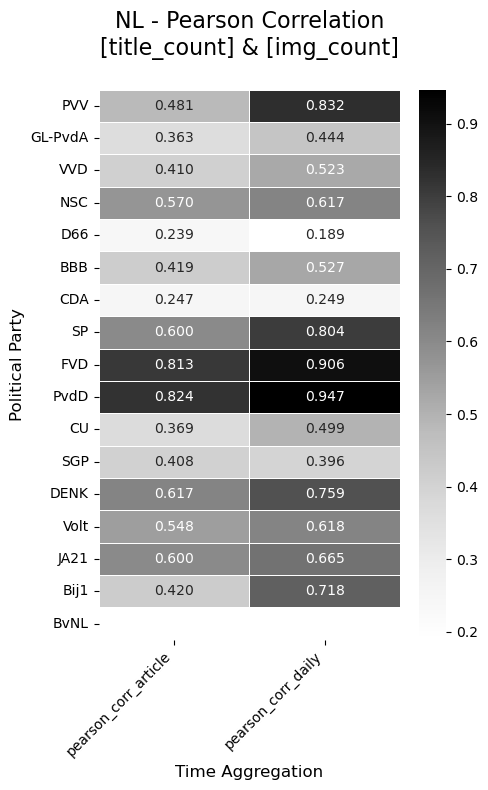

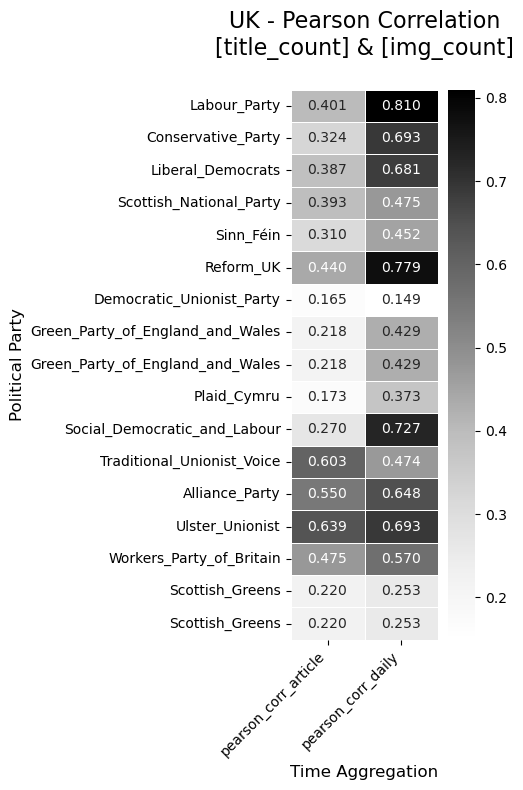

In [24]:
plot_correlation_heatmap(nl_corr_title, 'title', 'NL')
plot_correlation_heatmap(uk_corr_title, 'title', 'UK')

In [53]:
def correlate_modalities_day(df, pol_party_dict, text_mod):
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    party_modalities = []
    
    for party in pol_party_dict.values():
        text_count = df[f"{party}__{text_mod}_count"]
        img_count = df[f"{party}__img_count"]
        
        text_count_norm = zscore(text_count)
        img_count_norm = zscore(img_count)

        score = {
            'party': party,
            'pearson_corr_article': np.round(pd.Series(text_count_norm).corr(pd.Series(img_count_norm)), 3)
        }

        cols_to_sum = [f"{party}__{text_mod}_count", f"{party}__img_count"]

        daily_df = df[cols_to_sum].resample('D').sum()
        if not daily_df.empty:
            daily_text_norm = zscore(daily_df[f"{party}__{text_mod}_count"])
            daily_img_norm = zscore(daily_df[f"{party}__img_count"])
            score['pearson_corr_daily'] = np.round(pd.Series(daily_text_norm).corr(pd.Series(daily_img_norm)), 3)
        else:
            score['pearson_corr_daily'] = None
        
        party_modalities.append(score)
    
    party_modalities_df = pd.DataFrame(party_modalities)

    # ✅ Now compute dataset-wide coverage across all parties
    all_text_cols = [f"{p}__{text_mod}_count" for p in pol_party_dict.values()]
    all_img_cols = [f"{p}__img_count" for p in pol_party_dict.values()]

    daily_totals = df[all_text_cols + all_img_cols].resample("D").sum()

    days_with_any_text = (daily_totals[all_text_cols].sum(axis=1) > 0).sum()
    days_with_any_img = (daily_totals[all_img_cols].sum(axis=1) > 0).sum()

    print(f"{df['country'].iloc[1]} - Days with at least one {text_mod} occurrence across parties: {days_with_any_text}")
    print(f"{df['country'].iloc[1]} - Days with at least one image occurrence across parties: {days_with_any_img}")

    return party_modalities_df


In [54]:
nl_corr_title = correlate_modalities_day(nl_multimodal_counted, nl23_politician_party, 'title')
uk_corr_title = correlate_modalities_day(uk_multimodal_counted, uk24_politician_party, 'title')

NL - Days with at least one title occurrence across parties: 104
NL - Days with at least one image occurrence across parties: 94
UK - Days with at least one title occurrence across parties: 153
UK - Days with at least one image occurrence across parties: 149


## 4. Summary reports

In [24]:
def print_significance(p_value):
    if p_value < 0.001: return '***'
    elif p_value < 0.01: return '**'
    elif p_value < 0.05: return '*'
    else: return '-'

In [25]:
def analyze_appearance_relationship(df, pol_party_dict):
    results = []
    
    for party in pol_party_dict.values():
        text_col = f"{party}__text_count"
        title_col = f"{party}__title_count"
        img_col = f"{party}__img_count"
        
        total_articles = len(df)
        articles_with_img = df[img_col].sum()
        img_prob = articles_with_img / total_articles
        
        try:
            corr_text, p_value_text = pointbiserialr(df[img_col], df[text_col])
            corr_title, p_value_title = pointbiserialr(df[img_col], df[title_col])
            
            mean_text_with_img = df[df[img_col] == 1][text_col].mean()
            mean_text_without_img = df[df[img_col] == 0][text_col].mean()

            mean_title_with_img = df[df[img_col] == 1][title_col].mean()
            mean_title_without_img = df[df[img_col] == 0][title_col].mean()
            
        except ValueError:
            corr_text, corr_title, p_value_text, p_value_title = None, None, None, None
            mean_text_with_img, mean_text_without_img = None
            mean_title_with_img, mean_title_without_img = None, None
        
        results.append({
            'party': party,
            'articles_with_images': articles_with_img,
            'image_probability': round(img_prob, 4),
            'correlation_text_img': round(corr_text, 3) if corr_text is not None else None,
            'p_value_text_img': print_significance(p_value_text),
            'mean_text_when_imaged': round(mean_text_with_img, 2) if mean_text_with_img is not None else None,
            'mean_text_when_not_imaged': round(mean_text_without_img, 2) if mean_text_without_img is not None else None,
            'correlation_title_img': round(corr_title, 3) if corr_title is not None else None,
            'p_value_title_img': print_significance(p_value_title),
            'mean_title_when_imaged': round(mean_title_with_img, 2) if mean_title_with_img is not None else None,
            'mean_title_when_not_imaged': round(mean_title_without_img, 2) if mean_title_without_img is not None else None
        })
    
    return pd.DataFrame(results)

In [26]:
nl_summary = analyze_appearance_relationship(nl_multimodal_counted, nl23_politician_party)
uk_summary = analyze_appearance_relationship(uk_multimodal_counted, uk24_politician_party)

/Users/wiesruyters/miniconda3/envs/eotw_env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


In [27]:
nl_summary

,party,articles_with_images,image_probability,correlation_text_img,p_value_text_img,mean_text_when_imaged,mean_text_when_not_imaged,correlation_title_img,p_value_title_img,mean_title_when_imaged,mean_title_when_not_imaged
0,PVV,75,0.0063,0.553,***,10.68,0.10,0.481,***,0.53,0.00
1,GL-PvdA,30,0.0025,0.508,***,8.87,0.08,0.363,***,0.40,0.00
2,VVD,66,0.0055,0.509,***,10.33,0.20,0.410,***,0.56,0.01
3,NSC,67,0.0056,0.642,***,9.30,0.07,0.570,***,0.54,0.00
4,D66,31,0.0026,0.330,***,6.03,0.11,0.239,***,0.29,0.00
5,BBB,37,0.0031,0.501,***,7.14,0.06,0.419,***,0.43,0.00
6,CDA,18,0.0015,0.341,***,9.22,0.12,0.247,***,0.39,0.00
7,SP,21,0.0018,0.624,***,10.33,0.03,0.600,***,0.57,0.00
8,FVD,25,0.0021,0.763,***,13.04,0.02,0.813,***,0.92,0.00
9,PvdD,35,0.0029,0.724,***,11.83,0.03,0.824,***,0.91,0.00


In [28]:
uk_summary

,party,articles_with_images,image_probability,correlation_text_img,p_value_text_img,mean_text_when_imaged,mean_text_when_not_imaged,correlation_title_img,p_value_title_img,mean_title_when_imaged,mean_title_when_not_imaged
0,Labour_Party,531,0.0065,0.427,***,16.98,0.58,0.401,***,0.78,0.02
1,Conservative_Party,403,0.0049,0.396,***,13.33,0.38,0.324,***,0.64,0.02
2,Reform_UK,133,0.0016,0.462,***,10.52,0.09,0.440,***,0.65,0.00
3,Liberal_Democrats,62,0.0008,0.442,***,9.39,0.06,0.387,***,0.65,0.00
4,Green_Party_of_England_and_Wales,51,0.0006,0.340,***,10.29,0.10,0.218,***,0.55,0.00
5,Green_Party_of_England_and_Wales,51,0.0006,0.340,***,10.29,0.10,0.218,***,0.55,0.00
6,Scottish_National_Party,69,0.0008,0.435,***,19.12,0.08,0.393,***,0.81,0.00
7,Sinn_Féin,14,0.0002,0.262,***,8.93,0.04,0.310,***,0.86,0.00
8,Workers_Party_of_Britain,7,0.0001,0.494,***,12.29,0.01,0.475,***,1.00,0.00
9,Plaid_Cymru,16,0.0002,0.251,***,10.06,0.07,0.173,***,0.56,0.00


Set data for visuals

In [47]:
import math
nl23_political_parties = ['PVV', 'GL-PvdA', 'VVD', 'NSC', 'D66', 'BBB', 'CDA', 'SP', 'FVD', 'PvdD', 'CU', 'SGP', 'DENK', 'Volt', 'JA21', 'Bij1', 'BvNL']
election_results = [37, 25, 24, 20, 9, 7, 5, 5, 3, 3, 3, 3, 3, 1, 1, 0, 0]

# Square root scaling - better visual representation
base_height = 20  # 2cm base
scale_factor = 15  # adjust this to control bar heights

scaled_heights = [(base_height + scale_factor * math.sqrt(seats)) / 10 for seats in election_results]

for party, seats, height in zip(nl23_political_parties, election_results, scaled_heights):
    print(f"{party}: {seats} seats -> {height:.1f}cm")

PVV: 37 seats -> 11.1cm
GL-PvdA: 25 seats -> 9.5cm
VVD: 24 seats -> 9.3cm
NSC: 20 seats -> 8.7cm
D66: 9 seats -> 6.5cm
BBB: 7 seats -> 6.0cm
CDA: 5 seats -> 5.4cm
SP: 5 seats -> 5.4cm
FVD: 3 seats -> 4.6cm
PvdD: 3 seats -> 4.6cm
CU: 3 seats -> 4.6cm
SGP: 3 seats -> 4.6cm
DENK: 3 seats -> 4.6cm
Volt: 1 seats -> 3.5cm
JA21: 1 seats -> 3.5cm
Bij1: 0 seats -> 2.0cm
BvNL: 0 seats -> 2.0cm


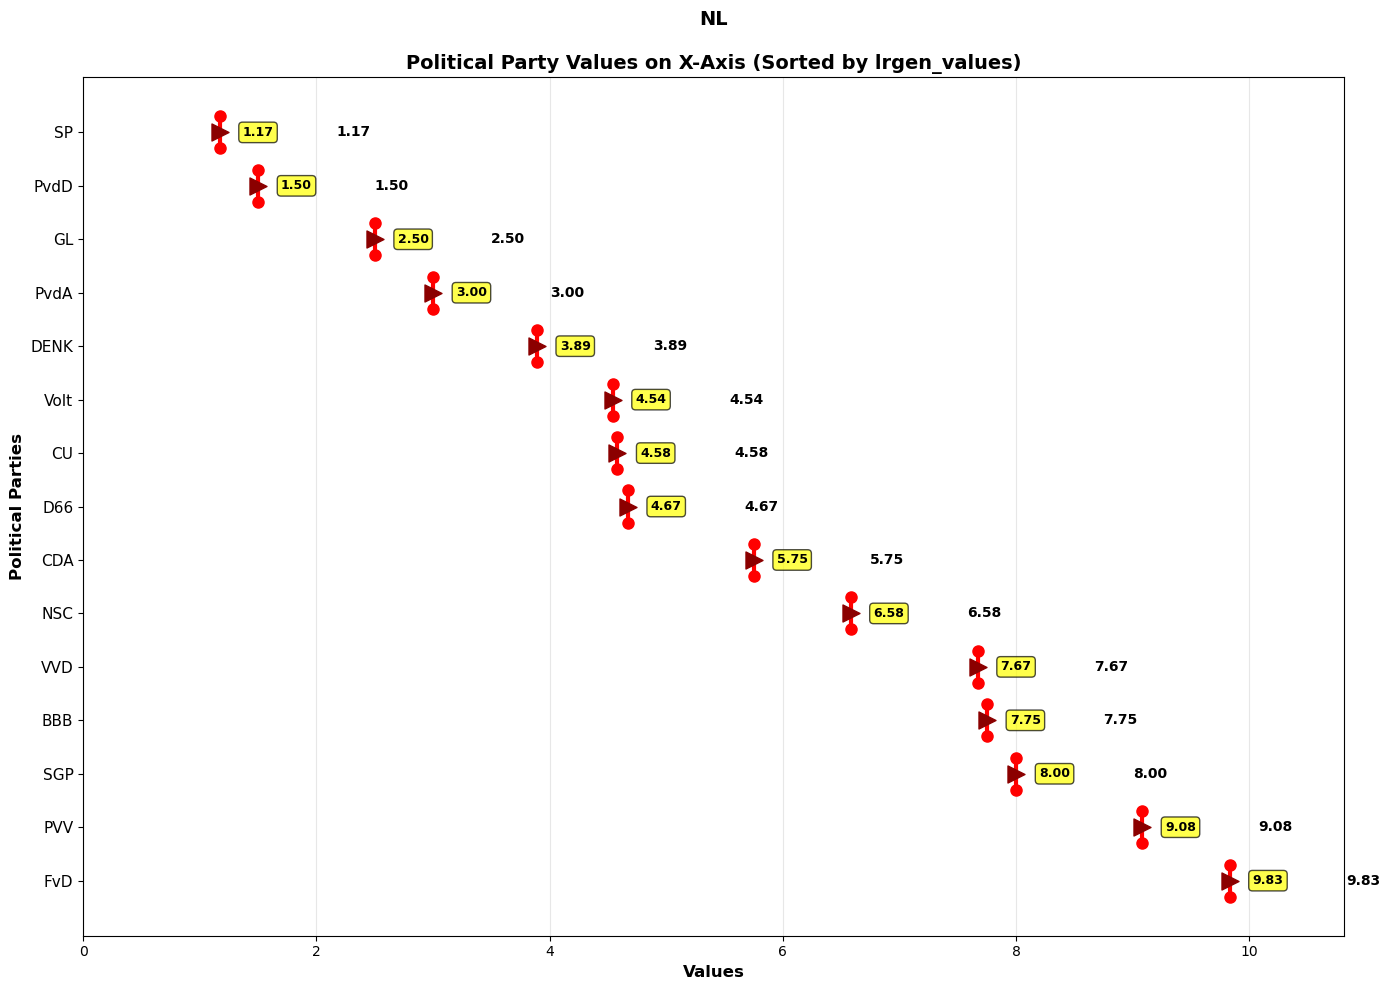

In [41]:
keys = ['CDA', 'PvdA', 'VVD', 'D66', 'GL', 'SGP', 'SP', 'CU', 'PVV', 'PvdD', 'DENK', 'FvD', 'Volt', 'BBB', 'NSC']
lrgen_values = [5.75, 3, 7.67, 4.67, 2.5, 8, 1.17, 4.58, 9.08, 1.5, 3.89, 9.83, 4.54, 7.75, 6.58]

# Sort the data by lrgen_values in descending order
sorted_indices = np.argsort(lrgen_values)[::-1]  # Get indices that would sort the array in descending order
sorted_keys = [keys[i] for i in sorted_indices]
sorted_lrcon = [lrgen_values[i] for i in sorted_indices]

# Create the plot
plt.figure(figsize=(14, 10))

# Create y positions for each key (evenly spaced on y-axis)
y_positions = np.arange(len(sorted_keys))

# Plot horizontal line for each key at its x-value
for i, (key, value) in enumerate(zip(sorted_keys, sorted_lrcon)):
    plt.plot([value, value], [i-0.3, i+0.3], 'o-', color='red', linewidth=3, markersize=8)
    plt.text(value + 1, i, f'{value:.2f}', va='center', fontsize=10, fontweight='bold')

# Add pointers/markers
plt.scatter(sorted_lrcon, y_positions, color='darkred', s=150, zorder=5, marker='>')

# Customize the plot
plt.yticks(y_positions, sorted_keys, fontsize=11)
plt.xlabel('Values', fontsize=12, fontweight='bold')
plt.ylabel('Political Parties', fontsize=12, fontweight='bold')
plt.title('NL\n\nPolitical Party Values on X-Axis (Sorted by lrgen_values)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.xlim(0, max(sorted_lrcon) * 1.1)  # Add some padding

# Add value labels on the right
for i, value in enumerate(sorted_lrcon):
    plt.text(value + max(sorted_lrcon)*0.02, i, f'{value:.2f}', 
             va='center', fontsize=9, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()

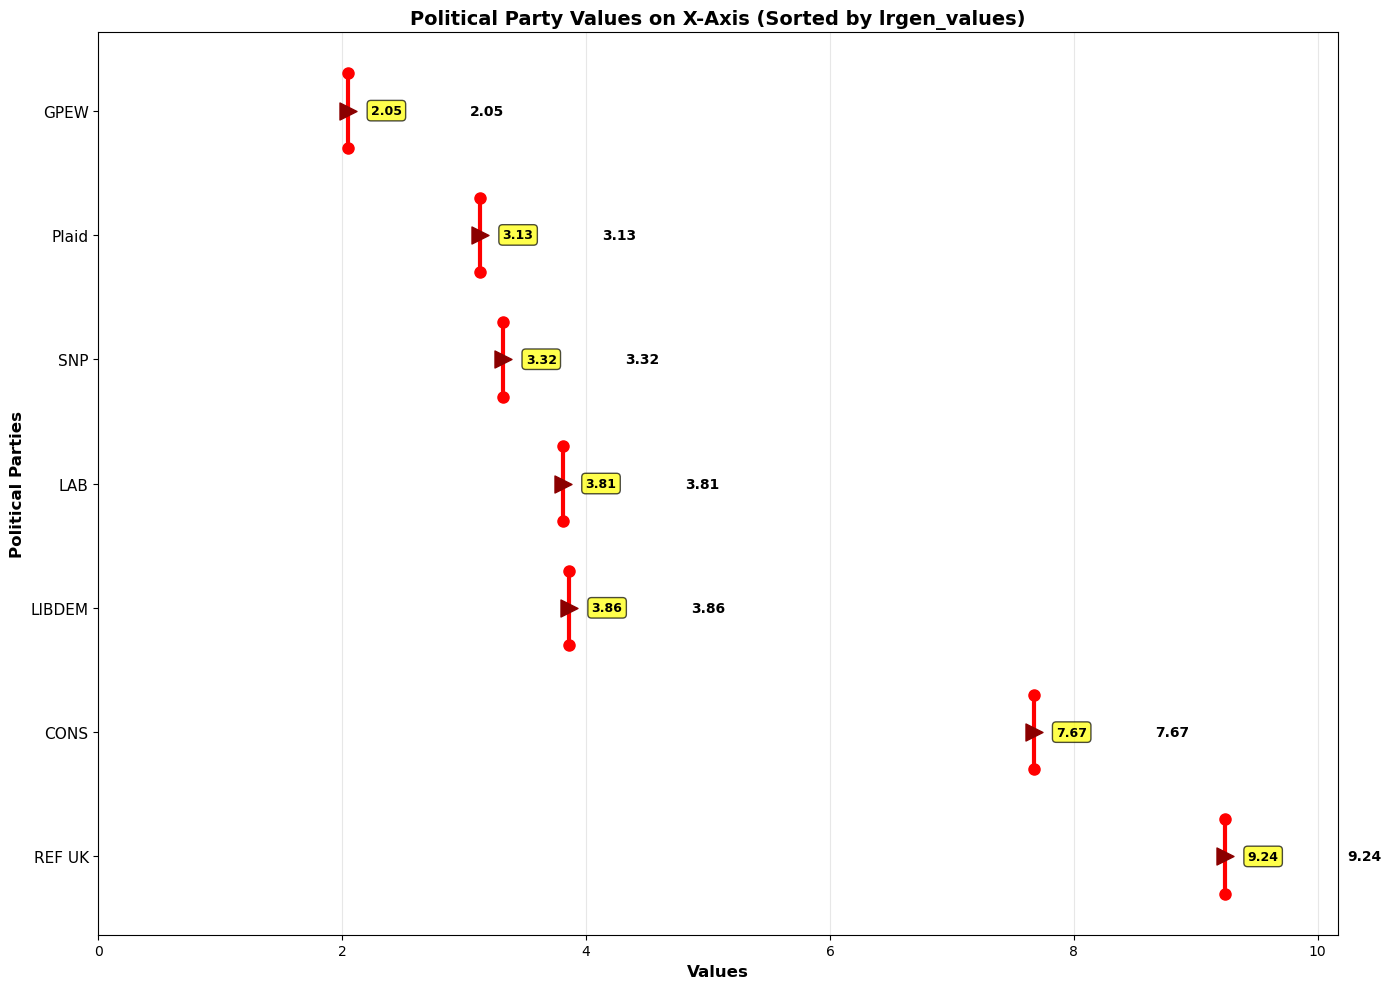

In [42]:
keys = ['CONS', 'LAB', 'LIBDEM', 'SNP', 'Plaid', 'GPEW', 'REF UK']
lrgen_values = [7.67, 3.81, 3.86, 3.32, 3.13, 2.05, 9.24]

# Sort the data by lrgen_values in descending order
sorted_indices = np.argsort(lrgen_values)[::-1]  # Get indices that would sort the array in descending order
sorted_keys = [keys[i] for i in sorted_indices]
sorted_lrcon = [lrgen_values[i] for i in sorted_indices]

# Create the plot
plt.figure(figsize=(14, 10))

# Create y positions for each key (evenly spaced on y-axis)
y_positions = np.arange(len(sorted_keys))

# Plot horizontal line for each key at its x-value
for i, (key, value) in enumerate(zip(sorted_keys, sorted_lrcon)):
    plt.plot([value, value], [i-0.3, i+0.3], 'o-', color='red', linewidth=3, markersize=8)
    plt.text(value + 1, i, f'{value:.2f}', va='center', fontsize=10, fontweight='bold')

# Add pointers/markers
plt.scatter(sorted_lrcon, y_positions, color='darkred', s=150, zorder=5, marker='>')

# Customize the plot
plt.yticks(y_positions, sorted_keys, fontsize=11)
plt.xlabel('Values', fontsize=12, fontweight='bold')
plt.ylabel('Political Parties', fontsize=12, fontweight='bold')
plt.title('Political Party Values on X-Axis (Sorted by lrgen_values)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.xlim(0, max(sorted_lrcon) * 1.1)  # Add some padding

# Add value labels on the right
for i, value in enumerate(sorted_lrcon):
    plt.text(value + max(sorted_lrcon)*0.02, i, f'{value:.2f}', 
             va='center', fontsize=9, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()